**Here we try crossing statistics with simulated light curves using Alex's method. For simplicity we first consider 2 images only. Also I changed some parameters in the light curve simulation.
nobs=80, fluc=1, t1=40.**
So we have more observation days finely spaced.

In [1]:
%reset -f

In [2]:
import lmfit
import matplotlib.pyplot as plt
import pystan
import emcee
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib
import numpy as np
import corner
#plt.rcParams['figure.figsize'] = [12, 8]

No. of data points in r,g,i,z bands= 80 80 80 80 respectively

Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.

Chi^2 original: r-band= 86.30284827238762 g-band= 70.31419754745815 i-band= 81.43267926800826 z-band= 83.66569606564407


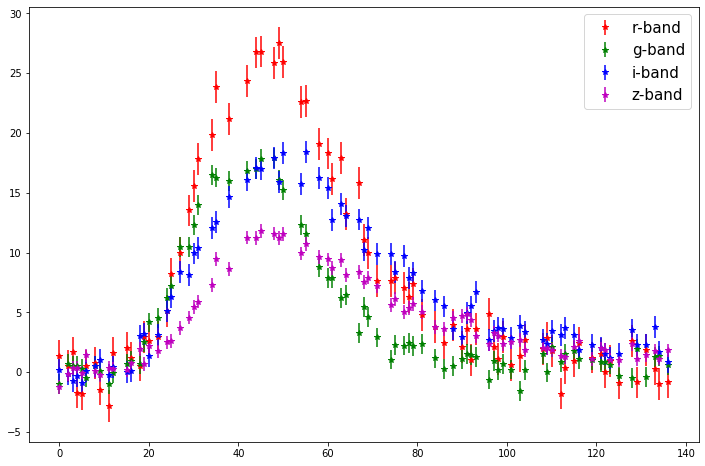

In [143]:
inp_path='Alex_sim_data/'
bands=['lsstg','lsstr','lssti','lsstz']
fileN='Alex_sim_lsst'

fileNr=inp_path+fileN+bands[1]+'.txt';#print(fileNr)
fileNg=inp_path+fileN+bands[0]+'.txt';#print(fileNg)
fileNi=inp_path+fileN+bands[2]+'.txt';#print(fileNi)
fileNz=inp_path+fileN+bands[3]+'.txt';#print(fileNz)

tr,fr,sigfr,fr1,fr2=np.loadtxt(fileNr,usecols=[0,1,2,3,4], unpack=True)
tg,fg,sigfg,fg1,fg2=np.loadtxt(fileNg,usecols=[0,1,2,3,4], unpack=True)
ti,fi,sigfi,fi1,fi2=np.loadtxt(fileNi,usecols=[0,1,2,3,4], unpack=True)
tz,fz,sigfz,fz1,fz2=np.loadtxt(fileNz,usecols=[0,1,2,3,4], unpack=True)

print("No. of data points in r,g,i,z bands=",len(tr), len(tz),len(ti),len(tz),"respectively\n")

t_mins=np.array([np.amin(tr), np.amin(tg), np.amin(ti), np.amin(tz)])
t_maxs=np.array([np.amax(tr), np.amax(tg), np.amax(ti), np.amax(tz)])
t_min=np.amin(t_mins)-1e-5; t_max=np.amax(t_maxs)+1e-5;

#we substract a fixed time, it should not have any effect on the pystan results
tr=tr-t_min; tg=tg-t_min; ti=ti-t_min; tz=tz-t_min;

t_max=t_max-t_min; t_min=0.0;

clr=['r','g','b','k']
plt.rcParams['figure.figsize'] = [12, 8]
plt.errorbar(tr,fr,yerr=sigfr,fmt="r*",label=r"r-band")
plt.errorbar(tg,fg,yerr=sigfg,fmt="g*",label=r"g-band")
plt.errorbar(ti,fi,yerr=sigfi,fmt="b*",label=r"i-band")
plt.errorbar(tz,fz,yerr=sigfz,fmt="m*",label=r"z-band")
plt.legend(loc=0,fontsize=15)


fro=fr1+fr2;fgo=fg1+fg2;fio=fi1+fi2;fzo=fz1+fz2
chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
print("Since we know the underlying model, we can calculate the Chi^2 in this simulation for the actual model. This might be handy later.")
print("\nChi^2 original: r-band=",chisqro,"g-band=",chisqgo,"i-band=",chisqio,"z-band=",chisqzo)


First we try the template 2, equ(20) of our report, with crossing statistics up to order 2, see equ(18).
Here we model the earlier image using the template+crossing statics, relative amplitude and time delay should describe the later image.

The system has two images: $\mu=2.4,1.4$ and $dt=16.2,1.2$. SInce below we mainly model the earlier image with the intrinsic flux model, we expect to find $\mu=1.4/2.4=0.583$ and $dt=16.2-1.2=15.0$.

In [155]:
mu_des=1.4/2.4; dt_des=15.0;# expected mu and dt after fitting

In [92]:
#template 2: t^n exp(-t/tk); stretch, crossing statistics upto 2nd order

def mod2(x,t0,n,xk,s,c0,c1,c2,c3,c4):
    x=x-t0;
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(x**n)*np.exp(-x/xk)
    xmax=np.amax(x)
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('nr', 2.0, True, 1.0,4.0), ('tkr', 10.0, True, 1.0,40.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('ng', 2.0, True, 1.0,4.0), ('tkg', 10.0, True, 1.0,40.0),('sg', 0.01,True, 0.0,0.99))#, ;

p.add_many(('mu1', 0.58, True, 0.4,2.0),('dt1',1.0, True,0,30.0) ,('t0',10.0, True,0.0,30.0));
#p.add('dt2', value=0.50, min=0, max=10.0)
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0, False, -10,10) ,('c4r', 0.0,False, None,None))

p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0, False, -10,10) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 2.0, True, 1.0,4.0), ('tki', 10.0, True, 1.0,40.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, -10,10))

p.add_many(('nz', 2.0, True, 1.0,4.0), ('tkz', 10.0, True, 1.0,40.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod2(tr,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod2(tr-v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod2(tg,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod2(tg-v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfg;
    
    B3=(mod2(ti,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)
            +v['mu1']*mod2(ti-v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],0,0)-fi)/sigfi;
    
    B4=(mod2(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)
            +v['mu1']*mod2(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],0,0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res2 = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=3000, steps=150000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res2.params)

100%|██████████| 150000/150000 [2:34:19<00:00, 16.20it/s] 


The chain is shorter than 50 times the integrated autocorrelation time for 28 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3000;
tau: [13986.69814403 17307.35123195 14776.4562023  13814.38595289
 14321.52794845 17257.17603055 12058.30674437  5109.55701464
 11268.93959044 13471.66342873 15665.38572889 13413.11587751
 16909.73090112 17572.08629815 16697.40164439 14366.66474114
 14625.51794946 17340.85395258 17122.59013214 17814.8809737
 16889.69476586 16503.296764   16959.09419429 18414.84050434
 15318.84027236 16655.01757296 14794.98079245  8083.59687591]
[[Variables]]
    nr:         1.87747818 +/- 0.17585614 (9.37%) (init = 2)
    tkr:        8.68218061 +/- 1.81977557 (20.96%) (init = 10)
    sr:         0.19129418 +/- 0.17890566 (93.52%) (init = 0.01)
    ng:         1.72928669 +/- 0.18064088 (10.45%) (init = 2)
    tkg:        7.61424839 +/- 1.57474046 (20.68%) (init = 10)
    sg:         0.27792601 +/- 0.23528632 (84.66%) (init = 0.01)
    mu1:       

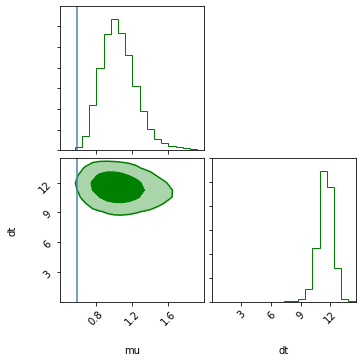

In [93]:
import corner
#print(res2.params.valuesdict().values())
emcee_plot = corner.corner(res2.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([1.4/2.4,15.0]))

The results are completely off the expectation. Below we try to see how the reconstructions from the maximum likelihood estimation (MLE) of the fitting look like.


Maximum likelihood Estimation
-----------------------------


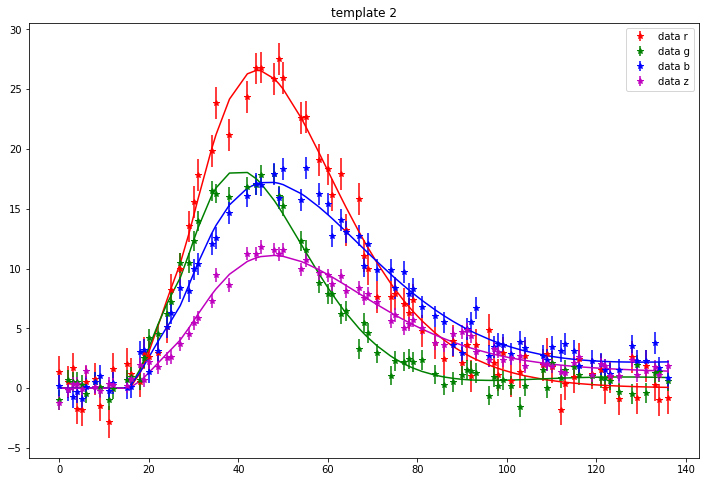

Maximum liklihood: mu= 0.8822606602901893 dt= 11.066877098558349
Chi^2 r= 92.38374118407611 Chi^2 g= 79.09253202510192 Chi^2 i= 78.0879623386316 Chi^2 z= 78.78553850576628
Chi^2 original: r= 86.30284827238762 g= 70.31419754745815 Chi^2 i= 81.43267926800826 Chi^2 z= 83.66569606564407


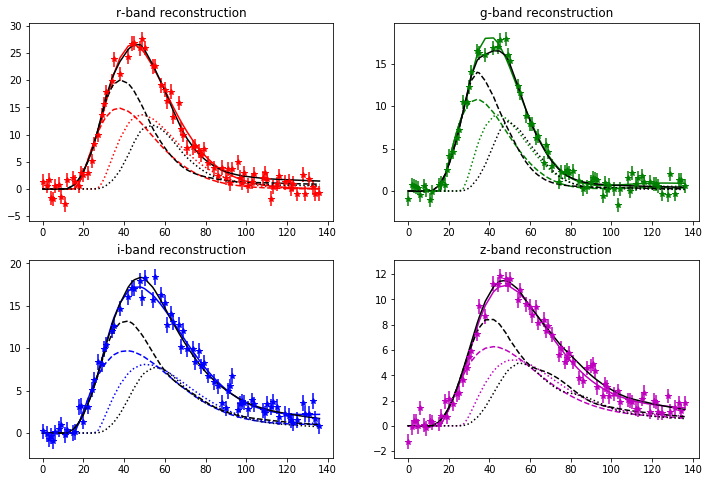

In [156]:
def plot_func2(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [nrm,tkrm,srm,ngm,tkgm,sgm,mum,dtm,t0m,c0rm,c1rm,c2rm,c0gm,c1gm,c2gm,
     nim,tkim,sim,c0im,c1im,c2im,nzm,tkzm,szm,c0zm,c1zm,c2zm,lnm]=mle_soln;
    #print(nrm,tkrm,ngm,tkgm,mum,dtm,t0m,c0rm,c1rm,c0gm,c1gm,c2gm,lnm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod2(tr,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Ps2r=mum*mod2(tr-dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,c4rm)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod2(tg,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Ps2g=mum*mod2(tg-dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,c4gm)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod2(ti,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod2(ti-dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod2(tz,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod2(tz-dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 2')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(tz, Psz, c="m")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("Chi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()
    
plot_func2(res2)

Altough the individual images are not recovered correctly, the fitting to the combined light curves are good.  

After observing some more cases, I believe the model $t^2 \exp(-t/t_k)$, even together with crossing statistics, can not describe the light curve of any particular image (at least in this choice of simulation parameter). That is why, probably, we are getting excellent fit to the combined light curves but the individual image lc's are not correctly recovered. 

Next we try log-normal template (equ (19)) with crossing statistics up to 2nd order.

In [95]:
#template 1: equ(19)
def mod(x,t0,n,xk,s,c0,c1,c2,c3,c4):    
    mean=n;sig=xk;
    x=x-t0;
    x=x-s*x;
    x[x<1e-15]=1e-15
    fx=(1.0/(sig*np.sqrt(2.0*np.pi)*x))*np.exp(-0.5*(np.log(x)-mean)**2/(sig*sig))
    xmax=np.amax(x)
    xs=x/xmax
    #print("len=",len(xs[xs<0.5]))
    fx_mod=fx*(c0+c1*xs+c2*(2.0*xs*xs-1)+c3*(4.0*xs*xs*xs-3.0*xs) + c4*(8.0*xs*xs*xs*xs-8.0*xs*xs+1.0));
    return fx_mod

#with lmfit emcee (MCMC)
p = lmfit.Parameters()
p.add_many(('mu1', 1.0, True, 0.4,2.0),('dt1',5.0, True,0,25.0) ,('t0',1.0, True,0.0,30.0));

p.add_many(('nr', 1.0, True, 0.1,10.0), ('tkr', 0.1, True, 0.0,3.0),('sr', 0.01,True, 0.0,0.99));
p.add_many(('c0r', 1.0, True,None,None),('c1r', 0.1, True, None,None),('c2r', 0.1, True, None,None),
           ('c3r', 0.0, False, None,None) ,('c4r', 0.0,False, None,None))

p.add_many(('ng', 1.0, True, 0.1,10.0), ('tkg', 0.1, True, 0.0,3.0),('sg', 0.01,True, 0.0,0.99))#, ;
p.add_many(('c0g', 1.0, True,None,None),('c1g', 0.1, True, None,None),('c2g', 0.1, True, None,None),
           ('c3g', 0.0,False, None,None) ,('c4g', 0.0,False, None,None))

p.add_many(('nni', 1.0, True, 0.0,10.0), ('tki', 0.1, True, 0.0,3.0),('si', 0.01,True, 0.0,0.99));
p.add_many(('c0i', 1.0, True,None,None),('c1i', 0.1, True, None,None),('c2i', 0.1, True, None,None),
          ('c3i', 0, False, None,None))

p.add_many(('nz', 1.0, True, 0.1,10.0), ('tkz', 0.10, True, 0.0,3.0),('sz', 0.01,True, 0.0,0.99));
p.add_many(('c0z', 1.0, True,None,None),('c1z', 0.1, True, None,None),('c2z', 0.1,True, None,None),
          ('c3z', 0, False, None,None))

def residual(p):
    v = p.valuesdict()
    
    B1=(mod(tr,v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])
            +v['mu1']*mod(tr-v['dt1'],v['t0'],v['nr'],v['tkr'],v['sr'],v['c0r'],v['c1r'],v['c2r'],v['c3r'],v['c4r'])-fr)/sigfr;
        
    B2=(mod(tg,v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])
            +v['mu1']*mod(tg-v['dt1'],v['t0'],v['ng'],v['tkg'],v['sg'],v['c0g'],v['c1g'],v['c2g'],v['c3g'],v['c4g'])-fg)/sigfr;
    
    B3=(mod(ti,v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)
            +v['mu1']*mod(ti-v['dt1'],v['t0'],v['nni'],v['tki'],v['si'],v['c0i'],v['c1i'],v['c2i'],v['c3i'],0)-fi)/sigfi;
    
    B4=(mod(tz,v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)
            +v['mu1']*mod(tz-v['dt1'],v['t0'],v['nz'],v['tkz'],v['sz'],v['c0z'],v['c1z'],v['c2z'],v['c3z'],0)-fz)/sigfz;
    
    return np.concatenate((B1,B2,B3,B4))


p.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=3000, steps=150000, thin=3, nwalkers=150,
                     params=p, is_weighted=False,seed=20145)
lmfit.report_fit(res.params)

100%|██████████| 150000/150000 [2:32:43<00:00, 16.37it/s]  


The chain is shorter than 50 times the integrated autocorrelation time for 28 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 3000;
tau: [14286.01195634 10873.16445601 12000.88384843 17551.83963321
 10160.87355005 16177.36011057 16319.06819866 15985.47426572
 15705.78046947 16868.74840871  9767.58687831 16701.40938088
 15035.62457468 15014.68611498 14930.57948873  9210.85767038
 10406.92926062 11680.64891435 19668.74715438 19579.51755867
 19512.25283163 17338.60141598  6470.91955318  3548.10492292
 18876.03827673 18964.76218037 18120.3611747   4891.45867339]
[[Variables]]
    mu1:        0.72635183 +/- 0.30112615 (41.46%) (init = 1)
    dt1:        12.7608041 +/- 1.57514860 (12.34%) (init = 5)
    t0:         4.91310551 +/- 2.91715592 (59.37%) (init = 1)
    nr:         2.45269808 +/- 0.59299987 (24.18%) (init = 1)
    tkr:        0.40256485 +/- 0.04683255 (11.63%) (init = 0.1)
    sr:         0.69324099 +/- 0.16805911 (24.24%) (init = 0.01)
    c0r:        

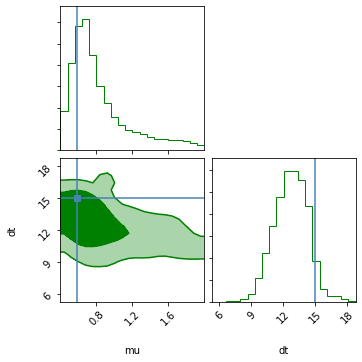

In [96]:
import corner
#print(res2.params.valuesdict().values())
emcee_plot = corner.corner(res.flatchain[['mu1','dt1']], labels=['mu','dt'],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=0,
                           truths=list([1.4/2.4,15.0]))

Not a great fit, but at least now we find our desired solution within $68\%$ contour.


Maximum likelihood Estimation
-----------------------------


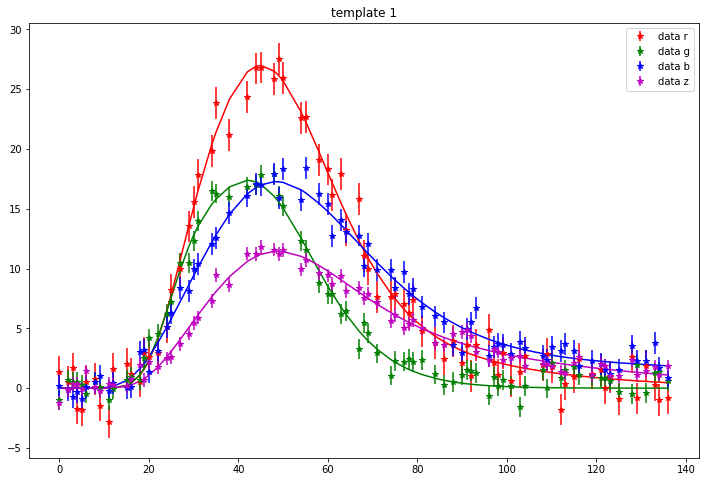

Maximum liklihood: mu= 0.49501952009989975 dt= 14.746481315158778

Chi^2 r= 78.33636722028338 Chi^2 g= 91.21593607475094 Chi^2 i= 70.42428630585907 Chi^2 z= 81.61382721677325
Chi^2 original: r= 86.30284827238762 g= 70.31419754745815 Chi^2 i= 81.43267926800826 Chi^2 z= 83.66569606564407


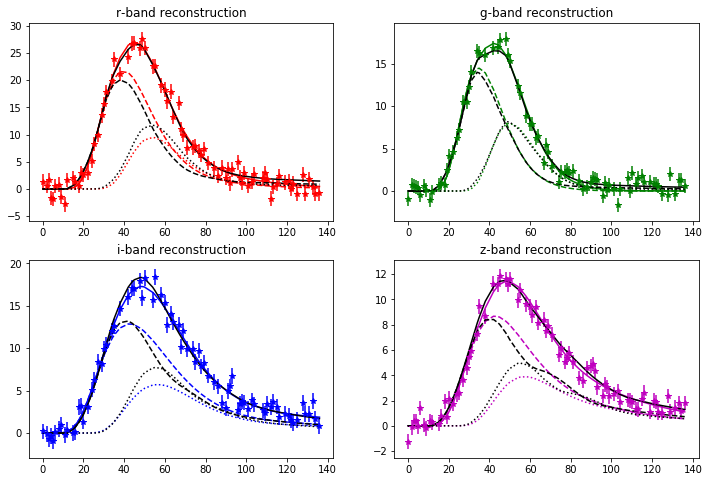

In [154]:
def plot_func(res):
    highest_prob = np.argmax(res.lnprob)
    hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
    mle_soln = res.chain[hp_loc]
    #print(mle_soln.shape)
    #sys.exit()
    #for i, par in enumerate(p):
    #p[par].value = mle_soln[i]
    #print(mle_soln[i])
    print("\nMaximum likelihood Estimation")
    print('-----------------------------')
    #print(len(mle_soln))
    c4rm=0; srm=0; c3rm=0;#mum=1.5;
    c4gm=0; sgm=0; c3gm=0;
    c2rm=c2gm=c2im=c2zm=0;
    [mum,dtm,t0m,
     nrm,tkrm,srm,c0rm,c1rm,c2rm,#c3rm,
     ngm,tkgm,sgm,c0gm,c1gm,c2gm,#c3gm,
     nim,tkim,sim,c0im,c1im,c2im,
     nzm,tkzm,szm,c0zm,c1zm,c2zm,
     lnm]=mle_soln;
    
    #print(mle_soln)
    #print("g-band: ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm=",ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm)
    #mum,dtm=1.4/2.4,15.0
    #print("Maximum liklihood: mu=",mum, "dt=",dtm)
    #sys.exit()
    #print(p)
    Ps1r=mod(tr,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Ps2r=mum*mod(tr-dtm,t0m,nrm,tkrm,srm,c0rm,c1rm,c2rm,c3rm,0)
    Psr=Ps1r+Ps2r
    fro=fr1+fr2
    
    Ps1g=mod(tg,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Ps2g=mum*mod(tg-dtm,t0m,ngm,tkgm,sgm,c0gm,c1gm,c2gm,c3gm,0)
    Psg=Ps1g+Ps2g
    fgo=fg1+fg2
    
    Ps1i=mod(ti,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Ps2i=mum*mod(ti-dtm,t0m,nim,tkim,sim,c0im,c1im,c2im,0,0)
    Psi=Ps1i+Ps2i
    fio=fi1+fi2
    
    Ps1z=mod(tz,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Ps2z=mum*mod(tz-dtm,t0m,nzm,tkzm,szm,c0zm,c1zm,c2zm,0,0)
    Psz=Ps1z+Ps2z
    fzo=fz1+fz2
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title(r'template 1')
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    #plt.plot(tr, Ps1r, c="r",ls="--")
    #plt.plot(tr, Ps2r, c="r",ls="dotted")
    
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    
    plt.errorbar(ti,fi,yerr=sigfi,fmt='b*',label=r"data b") #data
    plt.plot(ti, Psi, c="b")
    
    plt.errorbar(tz,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(tz, Psz, c="m")
 
    plt.legend(loc=0)
    plt.show()
    chisqr=np.sum((Psr-fr)**2/sigfr**2); chisqg=np.sum((Psg-fg)**2/sigfg**2);  
    chisqi=np.sum((Psi-fi)**2/sigfi**2); chisqz=np.sum((Psz-fz)**2/sigfz**2);
    c4gm
    chisqro=np.sum((fro-fr)**2/sigfr**2); chisqgo=np.sum((fgo-fg)**2/sigfg**2);
    chisqio=np.sum((fio-fi)**2/sigfi**2);chisqzo=np.sum((fzo-fz)**2/sigfz**2);
    #chisq_o=np.sum((ft_total-y)**2/sigft**2)
    print("Maximum liklihood: mu=",mum, "dt=",dtm)
    print("\nChi^2 r=",chisqr,"Chi^2 g=",chisqg,"Chi^2 i=",chisqi,"Chi^2 z=",chisqz)
    print("Chi^2 original: r=",chisqro,"g=",chisqgo,"Chi^2 i=",chisqio,"Chi^2 z=",chisqzo)
    plt.show()
    
    plt.subplot(2, 2, 1)
    plt.title(r'r-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tr,fr,yerr=sigfr,fmt='r*',label=r"data r") #data
    plt.plot(tr, Psr, c="r")
    plt.plot(tr, Ps1r,c="r",ls="--")
    plt.plot(tr, Ps2r,c="r",ls="dotted")
    plt.plot(tr, fro, c="k")
    plt.plot(tr, fr1,c="k",ls="--")
    plt.plot(tr, fr2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 2)
    plt.title(r'g-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(tg,fg,yerr=sigfg,fmt='g*',label=r"data g") #data
    plt.plot(tg, Psg, c="g")
    plt.plot(tg, Ps1g,c="g",ls="--")
    plt.plot(tg, Ps2g,c="g",ls="dotted")
    
    plt.plot(tg, fgo, c="k")
    plt.plot(tg, fg1,c="k",ls="--")
    plt.plot(tg, fg2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 3)
    plt.title(r'i-band reconstruction')
    plt.rcParams['figure.figsize'] = [6, 4]
    t=ti
    plt.errorbar(t,fi,yerr=sigfi,fmt='b*',label=r"data i") #data
    plt.plot(t, Psi, c="b")
    plt.plot(t, Ps1i,c="b",ls="--")
    plt.plot(t, Ps2i,c="b",ls="dotted")
    
    plt.plot(t, fio, c="k")
    plt.plot(t, fi1,c="k",ls="--")
    plt.plot(t, fi2,c="k",ls="dotted")
    
    plt.subplot(2, 2, 4)
    plt.title(r'z-band reconstruction')
    t=tz
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.errorbar(t,fz,yerr=sigfz,fmt='m*',label=r"data z") #data
    plt.plot(t, Psz, c="m")
    plt.plot(t, Ps1z,c="m",ls="--")
    plt.plot(t, Ps2z,c="m",ls="dotted")
    
    plt.plot(t, fzo, c="k")
    plt.plot(t, fz1,c="k",ls="--")
    plt.plot(t, fz2,c="k",ls="dotted")
    
    plt.show()

    
plot_func(res)

The recovered images are not bad. Note that we cannot use crossing statistics more than 2nd order because of the limitation of emcee handling many free parameters. 

Next we try the above in pystan (HMC): template 1 (eq(19)) with 2nd order crossing stat

In [99]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, real c0,real c1,real c2)//,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0));
                //+c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; //real c3r; real c4r;
    real c0g; real c1g; real c2g; //real c3g; real c4g;
    real c0i; real c1i; real c2i; //real c3i; real c4i;
    real c0z; real c1z; real c2z; //real c3z; real c4z;
    
    real<lower=0.4, upper=2.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=30.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit3 = sm.sampling(data=data, iter=120000, chains=4, warmup=4000, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc578544ef3df56293354abbe871e350 NOW.


Inference for Stan model: anon_model_cc578544ef3df56293354abbe871e350.
4 chains, each with iter=120000; warmup=4000; thin=3; 
post-warmup draws per chain=38667, total post-warmup draws=154668.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr   3.19    0.32   0.53   2.27   2.84   3.25   3.68   3.92      3   1.91
sigr    0.44    0.06    0.1   0.31   0.37   0.42   0.51   0.63      2   2.32
sr       0.5  2.7e-3   0.29   0.02   0.25    0.5   0.75   0.97  11179    1.0
meang   3.46    0.47   0.66   2.17    3.1   3.81   3.88   3.97      2   7.94
sigg    0.46    0.04   0.06   0.36   0.41   0.44   0.51   0.59      3    1.7
sg      0.49  2.7e-3   0.28   0.02   0.25   0.49   0.74   0.96  11143    1.0
meani   4.45    0.29   0.51   4.01   4.17   4.26   4.46   6.06      3    1.8
sigi     0.7    0.18   0.27   0.46   0.52   0.58   0.82   1.38      2   2.87
si       0.5  2.7e-3   0.29   0.03   0.25    0.5   0.74   0.97  11337    1.0
meanz   3.58    0.53   0.76   2.12  

**I have no idea why pystan faces these weired problems while sampling. In these sampling (template1 and 2 both) n_eff and Rhat always indicate some problem. I am working on this.**

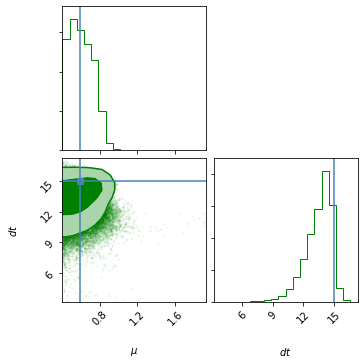

In [117]:
def contour(fit):
    #print("Expected: mu=",mu_expec, "dt=",dt_expec)
    la = fit.extract(permuted=True)
    mu_pos = np.vstack((la['mu'])).T
    dt_pos = np.vstack((la['dt'])).T
    #print(mu_pos.shape)
    #P_pos=np.vstack((la['P'])).T
    postsamples = np.vstack((mu_pos, dt_pos)).T
    #print(postsamples.shape)
    fig = corner.corner(postsamples, labels=[r"$\mu$", r"$dt$"],color='g', smooth=1,
                        levels=(0.68,0.95),plot_density=0, fill_contours=1, plot_datapoints=1,
                           truths=list([1.4/2.4,15.0]))
    #return fig
    
contour(fit3)

Anyway, our desired result is within 68%

Below we try the same with crossing statistics upto 4th order. We also put less strict prior on $\mu$.

In [113]:
model = """
functions{
    vector crossing_model(vector xx, real xm, real t0, int Nx, real mean,real sig, real s, 
    real c0,real c1,real c2,real c3,real c4)
    {
        
        vector[Nx] fx;
        vector[Nx] fx_mod;
        real xs;
        real x;
        int j;

      // /* j=1;
      //  while(xx[j]<=t0)
      //  {
      //      fx[j]=0;
      //      fx_mod[j]=0;
      //      j=j+1;
      //  
      //  }*/

        
        for (i in 1:Nx)
        {
            x=xx[i]-t0; xs=x/(xm-t0);
            if(x<=0)
            {
                fx[i]=0;
                fx_mod[i]=0;
            }
            else
            {
                fx[i]=(1.0/(sig*sqrt(2.0*pi())*x))*exp(-0.5*(log(x)-mean)*(log(x)-mean)/(sig*sig));
                fx_mod[i]=fx[i]*(c0+c1*xs+c2*(2.0*xs*xs -1.0)
                +c3*(4.0*xs*xs*xs-3.0*xs)+c4*(8.0*xs*xs*xs*xs-8.0*xs*xs + 1.0));
            }
        }
        
        
    
        return fx_mod;
    
    }


    
    //==============================================================================
}

data{

    int<lower=0> ni;

    int<lower=0> Nr;
    int<lower=0> Ng;
    int<lower=0> Ni;
    int<lower=0> Nz;

    vector[Nr] tr;
    vector[Nr] yr;
    vector[Nr] yr_error;
    real trm;

    vector[Ng] tg;
    vector[Ng] yg;
    vector[Ng] yg_error;
    real tgm;

    vector[Ni] ti;
    vector[Ni] yi;
    vector[Ni] yi_error;
    real tim;
    
    vector[Nz] tz;
    vector[Nz] yz;
    vector[Nz] yz_error;
    real tzm;
    
    real dt_max;
}
parameters {

    real<lower=0.0, upper=10.0> meanr; real<lower=0.0, upper=3.0> sigr; real<lower=0.0,upper=0.99> sr;
    real<lower=0.0, upper=10.0> meang; real<lower=0.0, upper=3.0> sigg; real<lower=0.0,upper=0.99> sg;
    real<lower=0.0, upper=10.0> meani; real<lower=0.0, upper=3.0> sigi; real<lower=0.0,upper=0.99> si;
    real<lower=0.0, upper=10.0> meanz; real<lower=0.0, upper=3.0> sigz; real<lower=0.0,upper=0.99> sz;
    
    real c0r; real c1r; real c2r; real c3r; real c4r;
    real c0g; real c1g; real c2g; real c3g; real c4g;
    real c0i; real c1i; real c2i; real c3i; real c4i;
    real c0z; real c1z; real c2z; real c3z; real c4z;
    
    real<lower=0.25, upper=4.0> mu;//actually measuring amplitudes relative 
    real <lower=0, upper=dt_max> dt;
    
    real<lower=0.0, upper=30.0> t0;
    
    
    
    
}


model {
    vector[Nr] dumr;
    vector[Ng] dumg;
    vector[Ni] dumi;
    vector[Nz] dumz;

    //dum needs
    dumr=crossing_model(tr, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);
    dumr=dumr+mu*crossing_model(tr-dt, trm, t0,Nr,meanr,sigr,sr, c0r,c1r,c2r,c3r,c4r);//adding the 2nd image
    target+=normal_lpdf(yr|dumr,yr_error);
    
    dumg=crossing_model(tg, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);
    dumg=dumg+mu*crossing_model(tg-dt, tgm, t0, Ng,meang,sigg,sg, c0g,c1g,c2g,c3g,c4g);//adding the 2nd image
    target+=normal_lpdf(yg|dumg,yg_error);
    
    dumi=crossing_model(ti, tim, t0, Ni,meani,sigi,si, c0i,c1i,c2i,c3i,c4i);
    dumi=dumi+mu*crossing_model(ti-dt, tim, t0,Ni,meani,sigi,si,c0i,c1i,c2i,c3i,c4i);//adding the 2nd image
    target+=normal_lpdf(yi|dumi,yi_error);
    
    dumz=crossing_model(tz,tzm, t0, Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);
    dumz=dumz+mu*crossing_model(tz-dt, tzm, t0,Nz,meanz,sigz,sz, c0z,c1z,c2z,c3z,c4z);//adding the 2nd image
    target+=normal_lpdf(yz|dumz,yz_error);
      

}
"""
NI=2

dt_min=0.0; dt_max=25.0

trm=np.amax(tr); tgm= np.amax(tg); tim= np.amax(ti); tzm=np.amax(tz);

data = {'ni':NI,
        'Nr': len(tr), 'Ng': len(tg), 'Ni': len(ti), 'Nz': len(tz),
        'tr': tr, 'yr': fr, 'yr_error':sigfr, 'trm':trm,
        'tg': tg, 'yg': fg, 'yg_error':sigfg, 'tgm':tgm,
        'ti': ti, 'yi': fi, 'yi_error':sigfi, 'tim':tim,
        'tz': tz, 'yz': fz, 'yz_error':sigfz, 'tzm':tzm,
        'dt_max':dt_max}

sm = pystan.StanModel(model_code=model)

fit4 = sm.sampling(data=data, iter=5000, chains=6, warmup=600, thin=3, seed=4201)#,control=dict(max_treedepth=15,adapt_delta=1.2))
print(fit4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d990ac32af49eae53a6de1afedf1f66e NOW.


Inference for Stan model: anon_model_d990ac32af49eae53a6de1afedf1f66e.
6 chains, each with iter=5000; warmup=600; thin=3; 
post-warmup draws per chain=1467, total post-warmup draws=8802.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
meanr   3.02    0.09   0.39   2.37   2.72   2.95   3.31   3.77     18   1.56
sigr    0.46    0.02   0.08   0.31    0.4   0.47   0.52   0.62     17   1.58
sr      0.51    0.01   0.28   0.03   0.27   0.51   0.76   0.96    540   1.01
meang   3.39    0.19   0.47   2.31   3.13   3.55   3.71   4.03      6   2.03
sigg    0.49    0.04    0.1   0.32   0.41   0.49   0.56   0.69      7   1.93
sg      0.48    0.02   0.28   0.02   0.23   0.47   0.72   0.96    346   1.01
meani   5.22    0.46   1.29   3.25   3.93    5.1   6.38   7.32      8   2.71
sigi    0.92    0.11   0.34   0.41   0.59   0.93    1.2   1.55     11   2.28
si      0.49    0.01   0.28   0.03   0.25   0.48   0.73   0.96    463   1.01
meanz   3.76    0.41   0.92   2.67   3.03 

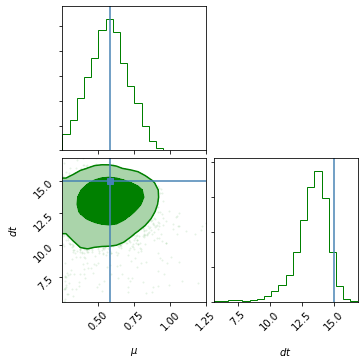

In [118]:
contour(fit4)

The result is consistent.

We did not try template2 + crossing stat in HMC yet. Actually all these methods give somehow reasonable result only if run very long chains which consume huge time.